# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

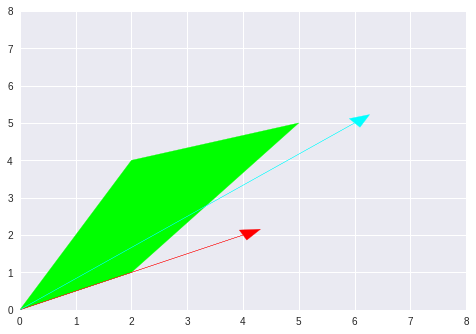

In [6]:
import numpy as np 
import matplotlib.pyplot as plt 



m_1 = np.matrix('4 6; 2 5')
plt.axis([0,8,0,8])
plt.arrow(0,0, m_1[0,0], m_1[1,0], head_width=.3, head_length=.35, color = 'red')
plt.arrow(0,0, m_1[0,1], m_1[1,1], head_width=.3, head_length=.35, color = 'cyan')
plt.fill([0,2,5,2],[0,1,5,4], color = 'lime')

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

I used a python library called numpy to create a matrix or a set of vectors. I then used another library to  visualize that matrix, called plotting. This gave me the red and blue vector lines, I used a metod in matplotlib which is my plotting library to create a shaded region in green. That represents an arbitrary normal distribution. 

2.  What was the most challenging part of what you did? Using plt.fill

3.  What was the most interesting thing you learned? The relationship between vectors in the matrix 

4.  What area would you like to explore with more time? How this applies to Machine Learning 




## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.